# Introduction (DRAFT)

In this document, we attempt to establish a direct correlation between the risk of COVID-19 infection, mortality, and smoking by exploring the Nexoid COVID-19 medical dataset. Additionally, we identify other insights and trends that provide a more nuanced overview of the subject, including the impact of pre-existing health conditions and lifestyle factors.

### References
- ?

# Data Type Corrections for Medical Dataset

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from pandas.api.types import CategoricalDtype

warnings.filterwarnings("ignore")

Matplotlib is building the font cache; this may take a moment.


## Load and Display Initial Data

In [8]:
# Load the dataset
df = pd.read_csv("medical-dataset.csv")

print("--- Initial Data Types ---")
print(df.dtypes)

--- Initial Data Types ---
survey_date                object
region                     object
country                    object
ip_latitude               float64
ip_longitude              float64
gender                     object
age                        object
height                      int64
weight                      int64
bmi                       float64
blood_type                 object
insurance                  object
income                     object
smoking                    object
alcohol                   float64
cocaine                   float64
contacts_count            float64
public_transport_count    float64
working                    object
worried                   float64
covid19_positive            int64
covid19_symptoms            int64
covid19_contact             int64
asthma                      int64
kidney_disease              int64
liver_disease               int64
compromised_immune          int64
heart_disease               int64
lung_disease         

In [9]:
# Check data type of 'insurance' column
print("Data type of 'insurance' column:", df['insurance'].dtype)

# Check for missing values
print("Number of missing values in 'insurance' column:", df['insurance'].isnull().sum())

# Display the first few rows of the 'insurance' column
print("First few rows of 'insurance' column:")
print(df['insurance'].head())

# Display the last few rows of 'insurance' column
print("Last few rows of 'insurance' column:")
print(df['insurance'].tail())

Data type of 'insurance' column: object
Number of missing values in 'insurance' column: 1292
First few rows of 'insurance' column:
0    yes
1    yes
2    yes
3    yes
4    yes
Name: insurance, dtype: object
Last few rows of 'insurance' column:
5784    NaN
5785    NaN
5786    NaN
5787    NaN
5788    NaN
Name: insurance, dtype: object


In [10]:
df['insurance'].value_counts()

insurance
yes      3544
no        622
blank     331
Name: count, dtype: int64

## Task 1: Data Type Corrections

We'll now implement the necessary data type corrections for each variable in the dataset.

### 1. Date Conversion

In [11]:
def convert_date(date_str):
    if pd.isna(date_str):
        return pd.NaT
    try:
        for fmt in ['%Y-%m-%d %H:%M:%S', '%d/%m/%Y', '%Y-%m-%d']:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue
        return pd.to_datetime(date_str, infer_datetime_format=True)
    except:
        return pd.NaT

df['survey_date'] = df['survey_date'].apply(convert_date)

### 2. Age - Convert to Ordered Categorical

In [12]:
df['age'] = df['age'].replace("100_110", "90_plus")
age_order = ['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', 
             '60_70', '70_80', '80_90', '90_plus']
age_dtype = pd.api.types.CategoricalDtype(categories=age_order, ordered=True)
df['age'] = df['age'].astype(age_dtype)

# Display age categories and their counts
print("Age Categories:")
print(df['age'].cat.categories)
print("\nAge Value Counts:")
df['age'].value_counts(sort=False)

Age Categories:
Index(['0_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_70', '70_80',
       '80_90', '90_plus'],
      dtype='object')

Age Value Counts:


age
0_10         14
10_20       205
20_30       996
30_40      1412
40_50      1111
50_60       926
60_70       765
70_80       354
80_90         0
90_plus       6
Name: count, dtype: int64

### 3. Gender - Convert to Nominal Categorical

In [13]:
df['gender'] = df['gender'].astype('category')
print("Gender Categories:")
df['gender'].value_counts()


Gender Categories:


gender
male      2985
female    2790
other       14
Name: count, dtype: int64

### 4. Region and Country - Convert to Categorical with 'Unknown'

In [14]:
for col in ['region', 'country']:
    df[col] = df[col].astype('category')
    if 'Unknown' not in df[col].cat.categories:
        df[col] = df[col].cat.add_categories('Unknown')
    df[col] = df[col].fillna('Unknown')
    
    print(f"\n{col.capitalize()} Categories:")
    print(df[col].value_counts())


Region Categories:
region
Unknown    4227
EU          801
SA          399
AS          206
AF           79
OC           77
Name: count, dtype: int64

Country Categories:
country
US    3885
GB     365
BR     270
CA     208
MX      94
      ... 
BS       1
BM       1
AZ       1
AW       1
JE       1
Name: count, Length: 95, dtype: int64


### 5. Height and Weight - Convert to Integer

In [15]:
df['height'] = df['height'].astype('Int64')  # Using Int64 to handle NaN values
df['weight'] = df['weight'].astype('Int64')

print("Height Summary:")
print(df['height'].describe())
print("\nWeight Summary:")
print(df['weight'].describe())

Height Summary:
count        5789.0
mean     172.030057
std         10.9176
min           110.0
25%           164.0
50%           172.0
75%           180.0
max           238.0
Name: height, dtype: Float64

Weight Summary:
count       5789.0
mean     84.773881
std        23.5763
min           44.0
25%           68.0
50%           82.0
75%           96.0
max          180.0
Name: weight, dtype: Float64


### 6. BMI - Keep as Float

In [16]:
df['bmi'] = df['bmi'].astype('float64')
print("BMI Summary:")
df['bmi'].describe()

BMI Summary:


count    5789.000000
mean       28.570116
std         7.674528
min        11.900000
25%        23.500000
50%        26.800000
75%        31.800000
max       125.000000
Name: bmi, dtype: float64

### 7. Blood Type - Convert to Categorical with 'Unknown'

In [17]:
df['blood_type'] = df['blood_type'].astype('category')
if 'Unknown' not in df['blood_type'].cat.categories:
    df['blood_type'] = df['blood_type'].cat.add_categories('Unknown')
df['blood_type'] = df['blood_type'].fillna('Unknown')

print("Blood Type Categories:")
df['blood_type'].value_counts()

Blood Type Categories:


blood_type
unknown    1784
ap         1279
op         1251
on          417
bp          394
an          244
abp         191
Unknown     100
bn           91
abn          38
Name: count, dtype: int64

### 8. Insurance - Convert to Boolean with NA for Blank and Unknown

In [18]:
df['insurance'] = df['insurance'].str.title()
df['insurance'] = df['insurance'].map({'Yes': True, 'No': False, 'Blank': pd.NA, 'Unknown': pd.NA})
print("Insurance Value Counts:")
df['insurance'].value_counts()

Insurance Value Counts:


insurance
True     3544
False     622
Name: count, dtype: int64

### 9. Income - Convert to Categorical

In [19]:
df['income'] = df['income'].astype('category')
print("Income Categories:")
df['income'].value_counts()

Income Categories:


income
med      2142
high     1886
low       398
blank     122
gov        88
Name: count, dtype: int64

### 10. Smoking - Convert to Categorical with Bins

In [20]:
smoking_bins = {
    'quit0': 'Former Smoker',
    'quit5': 'Former Smoker',
    'quit10': 'Former Smoker',
    'vape': 'Vape User',
    'yesheavy': 'Heavy Smoker',
    'light': 'Light Smoker',
    'medium': 'Medium Smoker',
    'never': 'Never Smoked',
    -1: 'Unknown'
}
df['smoking'] = df['smoking'].replace(smoking_bins)
df['smoking'] = df['smoking'].astype('category')

print("Smoking Categories:")
df['smoking'].value_counts()

Smoking Categories:


smoking
Never Smoked     3713
Former Smoker    1277
Vape User         247
yesmedium         230
yeslight          206
Heavy Smoker       80
Name: count, dtype: int64

### 11. Alcohol - Convert to Categorical Ordinal

In [22]:
df['alcohol'] = df['alcohol'].replace(-1, 'Unknown')
df['alcohol'] = df['alcohol'].astype('category')

print("Alcohol Categories:")
df['alcohol'].value_counts()

Alcohol Categories:


alcohol
Unknown    1920
0.0        1275
1.0         612
2.0         466
3.0         310
4.0         247
5.0         194
7.0         166
14.0        117
10.0        108
6.0          86
13.0         72
12.0         64
8.0          48
9.0          39
11.0         27
Name: count, dtype: int64

### 12. Cocaine - Convert to Categorical with Unknown

In [21]:
df['cocaine'] = df['cocaine'].replace(-1, 'Unknown')
df['cocaine'] = df['cocaine'].astype('category')

print("Cocaine Categories:")
df['cocaine'].value_counts()

Cocaine Categories:


cocaine
Unknown    1078
0.0         228
1.0          33
2.0          17
5.0          14
4.0          12
3.0          12
7.0           7
9.0           5
28.0          4
10.0          3
20.0          3
27.0          3
6.0           2
16.0          2
23.0          2
25.0          1
15.0          1
22.0          1
21.0          1
14.0          1
Name: count, dtype: int64

### 13. Contact Counts - Convert to Int64

In [23]:
df['contacts_count'] = df['contacts_count'].astype('Int64')
df['public_transport_count'] = df['public_transport_count'].astype('Int64')

print("Contacts Count Summary:")
print(df['contacts_count'].describe())
print("\nPublic Transport Count Summary:")
print(df['public_transport_count'].describe())

Contacts Count Summary:
count      5747.0
mean     7.828432
std      6.672943
min           0.0
25%           3.0
50%           5.0
75%          10.0
max          21.0
Name: contacts_count, dtype: Float64

Public Transport Count Summary:
count      4572.0
mean     0.415573
std      1.811049
min           0.0
25%           0.0
50%           0.0
75%           0.0
max          15.0
Name: public_transport_count, dtype: Float64


### 14. Working - Convert to Categorical

In [ ]:
df['working'] = df['working'].astype('category')
print("Working Status Categories:")
df['working'].value_counts()

### 15. Worried - Convert to Integer

In [24]:
df['worried'] = df['worried'].astype('Int64')
print("Worried Level Summary:")
df['worried'].describe()

Worried Level Summary:


count      4518.0
mean     3.530987
std      0.792812
min           1.0
25%           3.0
50%           4.0
75%           4.0
max           5.0
Name: worried, dtype: Float64

### 16. Health Conditions - Convert to Boolean

In [25]:
health_conditions = [
    'covid19_positive', 'covid19_symptoms', 'covid19_contact',
    'asthma', 'kidney_disease', 'liver_disease', 'compromised_immune',
    'heart_disease', 'lung_disease', 'diabetes', 'hiv_positive',
    'other_chronic', 'nursing_home', 'health_worker'
]

for col in health_conditions:
    df[col] = df[col].astype('bool')
    
print("Health Conditions Summary:")
for col in health_conditions:
    print(f"\n{col}:")
    print(df[col].value_counts())

Health Conditions Summary:

covid19_positive:
covid19_positive
False    3454
True     2335
Name: count, dtype: int64

covid19_symptoms:
covid19_symptoms
False    4792
True      997
Name: count, dtype: int64

covid19_contact:
covid19_contact
False    4800
True      989
Name: count, dtype: int64

asthma:
asthma
False    5032
True      757
Name: count, dtype: int64

kidney_disease:
kidney_disease
False    5726
True       63
Name: count, dtype: int64

liver_disease:
liver_disease
False    5745
True       44
Name: count, dtype: int64

compromised_immune:
compromised_immune
False    5444
True      345
Name: count, dtype: int64

heart_disease:
heart_disease
False    5607
True      182
Name: count, dtype: int64

lung_disease:
lung_disease
False    5654
True      135
Name: count, dtype: int64

diabetes:
diabetes
False    5320
True      469
Name: count, dtype: int64

hiv_positive:
hiv_positive
False    5766
True       23
Name: count, dtype: int64

other_chronic:
other_chronic
False    5411
True 

### 17. Risk Values - Convert to Float and Normalize

In [26]:
df['risk_infection'] = df['risk_infection'].astype('float64') / 100
df['risk_mortality'] = df['risk_mortality'].astype('float64') / 100

print("Risk Infection Summary:")
print(df['risk_infection'].describe())
print("\nRisk Mortality Summary:")
print(df['risk_mortality'].describe())

Risk Infection Summary:
count    5789.000000
mean        0.509772
std         0.440276
min         0.050000
25%         0.050000
50%         0.370000
75%         1.000000
max         1.000000
Name: risk_infection, dtype: float64

Risk Mortality Summary:
count    5789.000000
mean        0.005623
std         0.010778
min         0.000500
25%         0.000500
50%         0.001560
75%         0.005990
max         0.286980
Name: risk_mortality, dtype: float64


### 18. Drop longitude and latitude due to no meaningful significance

In [27]:
df.drop(columns=['ip_longitude', 'ip_latitude'], inplace=True)

## Final Data Types Check

In [28]:
print("Final Data Types:")
df.dtypes

Final Data Types:


survey_date               datetime64[ns]
region                          category
country                         category
gender                          category
age                             category
height                             Int64
weight                             Int64
bmi                              float64
blood_type                      category
insurance                         object
income                          category
smoking                         category
alcohol                         category
cocaine                         category
contacts_count                     Int64
public_transport_count             Int64
working                           object
worried                            Int64
covid19_positive                    bool
covid19_symptoms                    bool
covid19_contact                     bool
asthma                              bool
kidney_disease                      bool
liver_disease                       bool
compromised_immu

## Task 2 - Data Preparation - Identify issues and clean/transform

### 1. Identify Skewness in Numerical Variables

In [ ]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
skewness_results = {}

for col in numerical_cols:
    if col in df.columns:
        skewness = df[col].skew()
        skewness_results[col] = skewness
        print(f"{col}: {skewness:.3f}")

# Visualize distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(['height', 'weight', 'bmi', 'contacts_count', 'public_transport_count', 'worried', 'risk_infection', 'risk_mortality'], 1):
    plt.subplot(4, 2, i)
    df[col].hist(bins=30)
    plt.title(f'Distribution of {col} (Skewness: {df[col].skew():.3f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 2. Identify Missing Values and Errors

In [ ]:
print("Checking Missing Values in Each Column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

In [ ]:
print("Visualise the missing data...")
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title('Missing Values Heatmap')
plt.show()


In [ ]:
# Again as histogram
print(df.isnull().sum())

# Plotting missing values
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0] # Only plot columns with missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_counts.index, y=missing_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Count of Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.tight_layout()
plt.show()


In [ ]:
print("Potential Anomalies in Numerical Data:")
for col in ['height', 'weight', 'bmi', 'public_transport_count']:
    print(f"\n{col} - Outliers based on IQR:")
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"Number of outliers: {len(outliers)}")
    if len(outliers) > 0:
        print(f"Range of outliers: {outliers.min()} to {outliers.max()}")

     # Add a box plot for visualization
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Box plot of {col}")
    plt.xlabel(col)
    plt.show()


### 3. TODO - Continue clean and transformation at this point....

- Handle missing data in numerical cols - can we fill it with the median?
- For categorical cols, can we use mode or 'uknown'
- Need to handle outliers - do we maybe cap outliers?

### Fill missing Risk of Infection percentages with mean values within age brackets

In [209]:
# Calcu late the mean 'risk_infection' for each 'age' group
age_group_means = df.groupby('age')['risk_infection'].transform('mean')

# Fill missing 'risk_infection' values with the calculated age group means
df['risk_infection'].fillna(age_group_means, inplace=True)

# fill remaining NaNs with the global mean of 'risk_infection'
global_mean_risk_infection = df['risk_infection'].mean()
df['risk_infection'].fillna(global_mean_risk_infection, inplace=True)

# Verify that there are no more missing risk_infection values
print(f"Missing 'risk_infection' values after processing: {df['risk_infection'].isnull().sum()}")
print(df.groupby('age')['risk_infection'].mean().head())

Missing 'risk_infection' values after processing: 0
age
0_10     51.285714
10_20    60.321951
20_30    64.048192
30_40    55.339235
40_50    48.019801
Name: risk_infection, dtype: float64


### Fill Missing BMI Values with Median

In [29]:
bmi_median = df['bmi'].median()
df['bmi'].fillna(bmi_median, inplace=True)

print(f"Missing BMI values filled with median: {bmi_median}")
print(f"Number of remaining NaNs in BMI: {df['bmi'].isnull().sum()}")

Missing BMI values filled with median: 26.8
Number of remaining NaNs in BMI: 0


### 4. TODO - Visualise changes with histogram

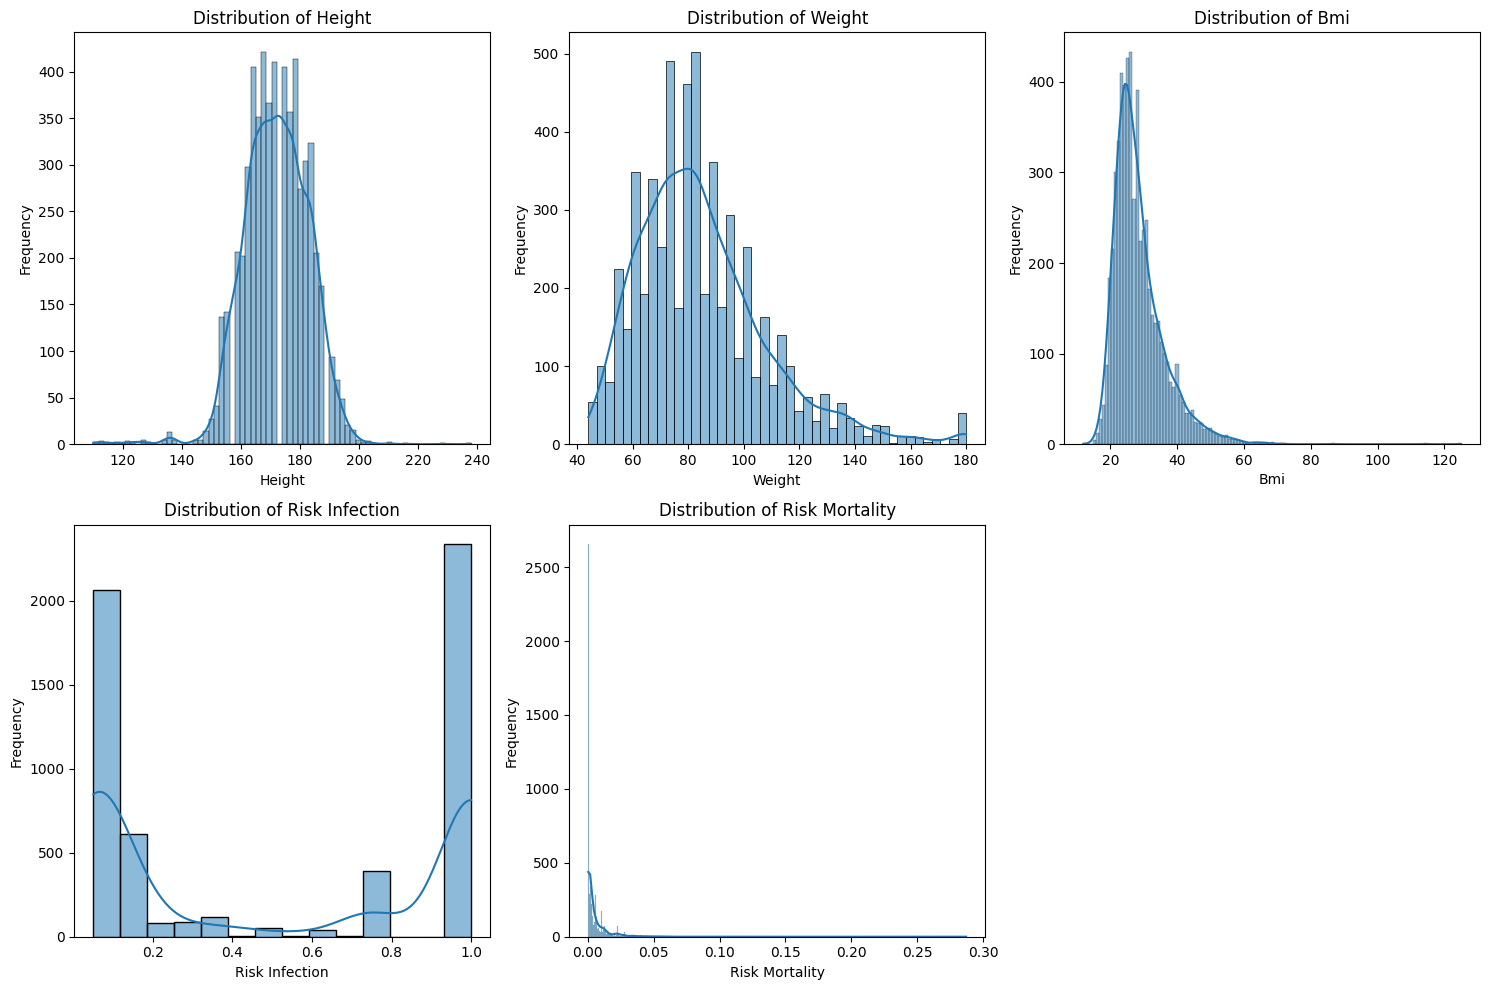

In [30]:
# NOT COMPLETE....can we use seaborn?
numerical_cols = ['height', 'weight', 'bmi', 'risk_infection', 'risk_mortality']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### 5. Data Preparation Reflection

While reviewing the dataset, we identified multiple areas of data inconsistencies caused by incorrect data entry, missing values, and extreme outliers. To analyze skewness and distribution patterns, we employed visualization techniques, generating histograms and box plots for key variables.

In some cases, we normalised data, such as standardising date formats to ensure uniformity across records. In other cases, we removed features entirely, such as *longitude* and *latitude*, to streamline data exploration and avoid unnecessary complexity.

For categorical features, we opted to fill missing values using the mode. For instance:
- Missing values in the *Smoking* attribute were replaced with the most common category: ????? {help?}.
- Missing values in the pre-existing conditions column were filled with ????? {help !!!}  to reflect the majority of the dataset.

For numerical features, our approach depended on the distribution:
- *BMI values* were filled using the median to prevent skewness from extreme values.
- *Risk of infection* percentages were replaced with mean values within age brackets to retain realistic trends.



# Task 3 - Data Mining and Feature Selection

i: Determine if there is a strong relationship between the variables covid19_positive and smoking? How would you handle these two variables in the data modelling based on your findings?

--- Frequency of covid19_positive ---
covid19_positive
False    0.596649
True     0.403351
Name: proportion, dtype: float64

--- Frequency of smoking ---
smoking
Never Smoked     0.645402
Former Smoker    0.221971
Vape User        0.042934
yesmedium        0.039979
yeslight         0.035807
Heavy Smoker     0.013906
Name: proportion, dtype: float64

--- Contingency Table ---
covid19_positive  False  True  % Positive
smoking                                  
Former Smoker       746   531       41.58
Heavy Smoker         33    47       58.75
Never Smoked       2313  1400       37.71
Vape User           122   125       50.61
yeslight            121    85       41.26
yesmedium           119   111       48.26


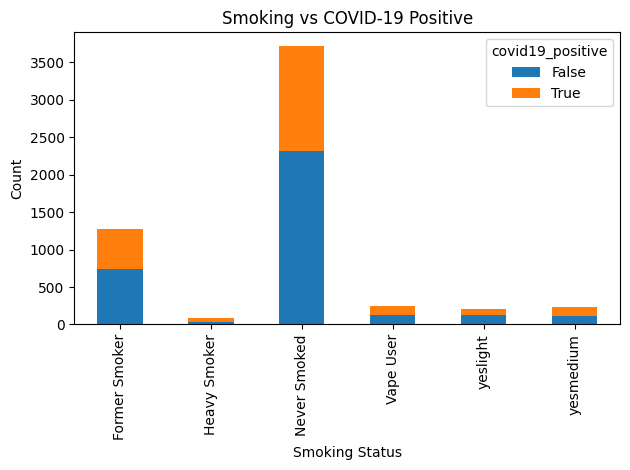


Chi-squared value: 39.46
p-value: 0.0000

--- COVID-19 Positive Rate within Smoking Categories ---
covid19_positive     False     True 
smoking                             
Former Smoker     0.584182  0.415818
Heavy Smoker      0.412500  0.587500
Never Smoked      0.622946  0.377054
Vape User         0.493927  0.506073
yeslight          0.587379  0.412621
yesmedium         0.517391  0.482609


In [38]:
from scipy.stats import chi2_contingency

# 1. Frequency distribution of each variable
print("--- Frequency of covid19_positive ---")
print(df["covid19_positive"].value_counts(normalize=True))

print("\n--- Frequency of smoking ---")
print(df["smoking"].value_counts(normalize=True))

# 2. Contingency table
contingency = pd.crosstab(df["smoking"], df["covid19_positive"])
contingency_display = contingency.copy()
contingency_display["% Positive"] = (contingency_display[True] / contingency_display.sum(axis=1)) * 100
contingency_display["% Positive"] = contingency_display["% Positive"].round(2)

print("\n--- Contingency Table ---")
print(contingency_display)

# 3. Visualisation
contingency.plot(kind="bar", stacked=True)
plt.title("Smoking vs COVID-19 Positive")
plt.ylabel("Count")
plt.xlabel("Smoking Status")
plt.tight_layout()
plt.show()


# 4. Chi-Squared Test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"\nChi-squared value: {chi2:.2f}")
print(f"p-value: {p:.4f}")

# 5. Percentage within each smoking group
percent_table = contingency.div(contingency.sum(axis=1), axis=0)
print("\n--- COVID-19 Positive Rate within Smoking Categories ---")
print(percent_table)


ii: Identify the highly correlated variable pairs and elaborate on how to treat these variables in the mining process.

chatGPT suggestion: 

To identify highly correlated variables, we computed a Pearson correlation matrix using all numeric variables. Variables with a correlation coefficient greater than 0.7 were flagged for further investigation. The strongest correlations included:
height and weight: expected due to their biological link. We retained only the BMI feature as it encapsulates both.
risk_infection and risk_mortality: possibly due to overlapping assessment methods. In downstream modelling, we may apply dimensionality reduction (e.g., PCA) or evaluate their contribution using feature importance.
covid19_contact and covid19_positive: since contact is a likely causal factor of positivity, we may exclude it in some models to avoid data leakage, depending on the task.
Proper treatment of correlated variables improves model generalisability and helps prevent overfitting or bias in feature interpretation.

In [34]:
# Filter numeric columns only
numeric_df = df.select_dtypes(include=["int64", "float64", "bool"])


# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Take the absolute value to focus on strength, not direction
abs_corr = corr_matrix.abs()

# Unstack, drop self-correlations, and filter
strong_corr = abs_corr.unstack().sort_values(ascending=False)
strong_corr = strong_corr[strong_corr < 1.0]  # remove self-correlation
strong_corr = strong_corr[strong_corr > 0.7]

# Drop duplicate pairs (e.g., A→B and B→A)
strong_corr = strong_corr[~strong_corr.duplicated()]
print(strong_corr)


risk_infection  covid19_positive    0.915573
bmi             weight              0.862463
dtype: float64
